In [1]:
%reset

In [76]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn

In [77]:
def mass_spring(y, args, kargs):
    q = y[:, 0]
    p = y[:, 1]
    dq_dt = p
    dp_dt = -q
    return torch.stack((dq_dt, dp_dt), dim=-1)

In [56]:
def double_well(y, args, kargs):
    q = y[:, 0]
    p = y[:, 1]
    dq_dt = p
    dp_dt = q - q**3
    return torch.stack((dq_dt, dp_dt), dim=-1)

In [27]:
def henon_heiles(y, args, kargs):
    q1, q2, p1, p2 = y[:, 0], y[:, 1], y[:, 2], y[:, 3]
    
    dq1 = p1
    dq2 = p2
    dp1 = -q1 - 2 * q1 * q2
    dp2 = -q2 - q1**2 + q2**2
    
    return torch.stack((dq1, dq2, dp1, dp2), dim=-1)

In [78]:
alpha = 0.5

In [79]:
# Dynamics for the non-separable Hamiltonian system
def coupled_ho(y, args, kargs):
    #alpha = args
    #alpha = 0.5
    q, p = y[:, 0], y[:, 1]
    dqdt = p + alpha * q
    dpdt = -q - alpha * p
    return torch.stack((dqdt, dpdt), dim=-1)

In [80]:
def forward_ode(y_tensor: torch.Tensor, args: tuple, kargs: dict) -> torch.Tensor:
    """
    y_tensor: [B,2N] concatenation of q,p
    args: (model,)
    returns: [B,2N] concatenation of dq_dt, dp_dt
    """
    model = args[0]
    with torch.enable_grad():
        y = y_tensor.clone().detach().requires_grad_(True)  # [B,2N]
        H = model.cal_H(y).squeeze(-1)                      # [B]
        grad_H = torch.autograd.grad(
            outputs=H.sum(),
            inputs=y,
            create_graph=True,
            retain_graph=True
        )[0]                                               # [B,2N]

    N2 = y.shape[1]
    N = N2 // 2
    dH_dq = grad_H[:, :N]    # [B,N]
    dH_dp = grad_H[:, N:]    # [B,N]

    dq_dt = dH_dp            # ∂H/∂p
    dp_dt = -dH_dq           # -∂H/∂q

    return torch.cat([dq_dt, dp_dt], dim=1)  # [B,2N]

In [81]:
import torch
import math

In [82]:
# --- model definition (must exactly match how you trained it) --- #
class LinearBlock(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.net(x)

class KTrained(nn.Module):
    def __init__(self, N, hidden_dim):
        super().__init__()
        self.N = N
        self.cal_H = nn.Sequential(
            LinearBlock(2 * N, hidden_dim),
            LinearBlock(hidden_dim, hidden_dim),
            LinearBlock(hidden_dim, hidden_dim),
            LinearBlock(hidden_dim, hidden_dim),
            LinearBlock(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, 1),
        )
        # same initialization as training
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.uniform_(
                    -math.sqrt(6. / m.in_features),
                     math.sqrt(6. / m.in_features)
                )

    def forward_train(self, q, p):
        with torch.enable_grad():
            x = torch.cat([q, p], dim=2)
            x = x.requires_grad_(True)
            K = self.cal_H(x.squeeze(1))
            dK = torch.autograd.grad(K.sum(), x, retain_graph=True, create_graph=True)[0]
        return dK[:, :, :self.N], dK[:, :, self.N:self.N * 2]

    def forward(self, q, p):
        with torch.enable_grad():
            x = torch.cat([q, p], dim=2)
            x = x.requires_grad_(True)
            K = self.cal_H(x.squeeze(1))
            dK = torch.autograd.grad(K.sum(), x, retain_graph=True, create_graph=False)[0]
        return dK[:, :, :self.N], dK[:, :, self.N:self.N * 2]

In [83]:
N = 1
hidden_dim = 64
device = 'cuda:0'
device = torch.device(device) if torch.cuda.is_available() else torch.device('cpu')
dynamics_name = "coupled_ho"


model = KTrained(N, hidden_dim).to(device)

# 2. Load the weights dict
raw_state = torch.load(f"/home/harsh/HNN/Baselines/{dynamics_name}_model_nssnn.pt", map_location=device)
new_state = {}
for k,v in raw_state.items():
    # turn “cal_H.0.left.0.weight” → “cal_H.0.net.0.weight”
    new_key = k.replace('.left.', '.net.')
    new_state[new_key] = v

model = KTrained(N, hidden_dim).to(device)
model.load_state_dict(new_state)
model.eval()
#model = torch.load('/home/harsh/HNN/models/model_0_coupled_ho_0.0_adjoint_True_7_im.pt')
#model = torch.load('/home/harsh/HNN/Baselines/double_well_model_nssnn.pt')
#model = torch.load('/home/harsh/HNN/models/model_0_henon_heiles_0.0_adjoint_True_7_im.pt')
#model.eval()  # Set the model to evaluation mode


/tmp/ipykernel_27837/3386089546.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_state = torch.load(f"/home/harsh/HNN/Baselines/{dynamics_name}_model_nssnn.pt", map_

KTrained(
  (cal_H): Sequential(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): Tanh()
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Tanh()
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Tanh()
      )
    )
    (3): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Tanh()
      )
    )
    (4): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): Tanh()
      )
    )
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [63]:
def H_pred(y_tensor: torch.Tensor, args: tuple, kargs: dict) -> torch.Tensor:
    """
    y_tensor: [B,2N] concatenation of q,p
    args: (model,)
    returns: [B] the scalar Hamiltonian for each sample
    """
    model = args[0]
    with torch.no_grad():
        H = model.cal_H(y_tensor).squeeze(-1)  # [B]
    return H

### HERE GOES ###

In [84]:
def H_pred_fn(Y: torch.Tensor) -> torch.Tensor:
    """
    Predict Hamiltonian values for a batch of (q,p) pairs.

    Args:
        Y: Tensor of shape (N, 2) where each row is [q, p].

    Returns:
        Tensor of shape (N,) containing H_pred(q,p).
    """
    with torch.no_grad():
        # If your model exposes `.cal_H`, use that:
        H = model.cal_H(Y)        # shape (N, 1)
        H = H.squeeze(-1)         # shape (N,)
        # Otherwise, if model(Y) directly returns (N,), you can do:
        # H = model(Y)
    return H

In [85]:
import numpy as np
import torch

def _evaluate_batch(
    Y: torch.Tensor,
    H_pred_fn,
    true_h_fn
) -> dict:
    """
    Evaluate predicted vs true Hamiltonian on a batch Y (shape (N,2)).
    Returns dict with:
      pred_h, true_h, offset, pred_h_corr, h_error, mean_abs_h
    """
    # 1) Predicted H
    with torch.no_grad():
        pred_h = H_pred_fn(Y).squeeze().cpu().numpy()  # (N,)

    # 2) True H
    q = Y[:, 0].cpu().numpy()
    p = Y[:, 1].cpu().numpy()
    true_h = true_h_fn(q, p)                         # (N,)

    # 3) Offset correction & error
    offset      = np.mean(pred_h - true_h)
    pred_h_corr = pred_h - offset
    h_error     = np.abs(pred_h_corr - true_h)
    mean_abs_h  = float(h_error.mean())

    return {
        "pred_h":      pred_h,
        "true_h":      true_h,
        "offset":      offset,
        "pred_h_corr": pred_h_corr,
        "h_error":     h_error,
        "mean_abs_h":  mean_abs_h,
    }

In [86]:
def evaluate_on_uniform_grid(
    H_pred_fn,
    true_h_fn,
    num_pts: int = 30,
    xlim: tuple = (-2, 2),
    ylim: tuple = (-2, 2),
    device: str = "cpu",
) -> dict:
    """
    Uniform grid in [xlim]×[ylim], num_pts per axis.
    Returns dict with Q,P mesh and Hamiltonian error arrays.
    """
    qv = np.linspace(xlim[0], xlim[1], num_pts)
    pv = np.linspace(ylim[0], ylim[1], num_pts)
    Q, P = np.meshgrid(qv, pv, indexing="xy")
    pts = np.stack([Q.ravel(), P.ravel()], axis=1)    # (N,2)
    Y = torch.tensor(pts, dtype=torch.float32, device=device)

    out = _evaluate_batch(Y, H_pred_fn, true_h_fn)

    # reshape results to grid
    for key in ("pred_h", "true_h", "pred_h_corr", "h_error"):
        out[key] = out[key].reshape(num_pts, num_pts)
    out["Q"], out["P"] = Q, P
    return out

In [87]:
def evaluate_on_random_uniform(
    H_pred_fn,
    true_h_fn,
    num_samples: int = 100000,
    xlim: tuple = (-2, 2),
    ylim: tuple = (-2, 2),
    device: str = "cpu",
) -> dict:
    """
    num_samples uniform points in [xlim]×[ylim].
    Returns dict with coords and Hamiltonian errors.
    """
    q = np.random.uniform(xlim[0], xlim[1], size=num_samples)
    p = np.random.uniform(ylim[0], ylim[1], size=num_samples)
    pts = np.column_stack([q, p])                     # (N,2)
    Y = torch.tensor(pts, dtype=torch.float32, device=device)

    out = _evaluate_batch(Y, H_pred_fn, true_h_fn)
    out["coords"] = pts
    return out

In [88]:
def evaluate_on_gaussian(
    H_pred_fn,
    true_h_fn,
    num_samples: int = 100000,
    mean: tuple = (0, 0),
    cov: list = [[1, 0], [0, 1]],
    device: str = "cpu",
) -> dict:
    """
    num_samples points from N(mean, cov).
    Returns dict with coords and Hamiltonian errors.
    """
    pts = np.random.multivariate_normal(mean, cov, size=num_samples)
    Y = torch.tensor(pts, dtype=torch.float32, device=device)

    out = _evaluate_batch(Y, H_pred_fn, true_h_fn)
    out["coords"] = pts
    return out

In [89]:
def true_h_fn(q,p):
    #return 0.5*p**2 + 0.25*q**4 - 0.5*q**2
    return 0.5*p**2 + 0.5*q**2 + alpha*p*q

# Wrap double_well so it gets the two None arguments
def true_dyn_fn(Y, args=None, kargs=None):
    #return double_well(Y, args, kargs)
    return coupled_ho(Y, args=None, kargs=None)

In [90]:
# 1) Uniform grid
res_grid = evaluate_on_uniform_grid(
    H_pred_fn,      # callable: Y->[N] predicted H
    true_h_fn,      # callable: (q,p)->[N] true H
    num_pts=30,
    xlim=(-2,2),
    ylim=(-2,2),
    device=device
)

In [91]:
# 2) Uniform random sampling
res_rand = evaluate_on_random_uniform(
    H_pred_fn,
    true_h_fn,
    num_samples=100000,
    xlim=(-2,2),
    ylim=(-2,2),
    device='cpu'
)

q_rand, p_rand   = res_rand["coords"].T
h_error_rand = res_rand["h_error"]


In [92]:
# 3) Gaussian sampling
res_gauss = evaluate_on_gaussian(
    H_pred_fn,
    true_h_fn,
    num_samples=100000,
    mean=(0,0),
    cov=[[1,0],[0,1]],
    device='cpu'
)
q_gauss, p_gauss = res_gauss["coords"].T
h_error_gauss   = res_gauss["h_error"]

In [93]:
mean_rand = res_rand["h_error"].mean()
sem_rand = res_rand["h_error"].std(ddof=1) / np.sqrt(len(res_rand["h_error"]))
print(f"Mean ± SEM: {mean_rand:.3f} ± {sem_rand:.3f}")

mean_grid = res_grid["h_error"].mean()
sem_grid = res_grid["h_error"].std(ddof=1) / np.sqrt(len(res_grid["h_error"]))
print(f"Mean ± SEM: {mean_grid:.3f} ± {sem_grid:.3f}")

mean_gauss = res_gauss["h_error"].mean()
sem_gauss = res_gauss["h_error"].std(ddof=1) / np.sqrt(len(res_gauss["h_error"]))
print(f"Mean ± SEM: {mean_gauss:.3f} ± {sem_gauss:.3f}")

Mean ± SEM: 0.806 ± 0.002
Mean ± SEM: 0.861 ± 0.139
Mean ± SEM: 0.795 ± 0.003


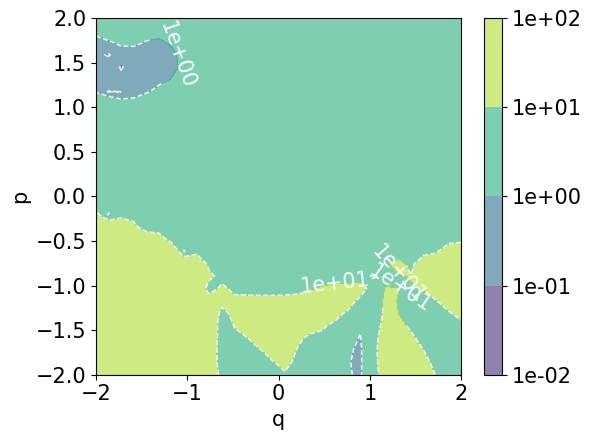

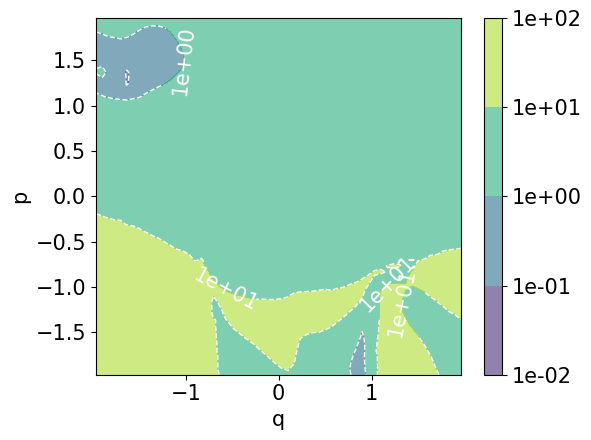

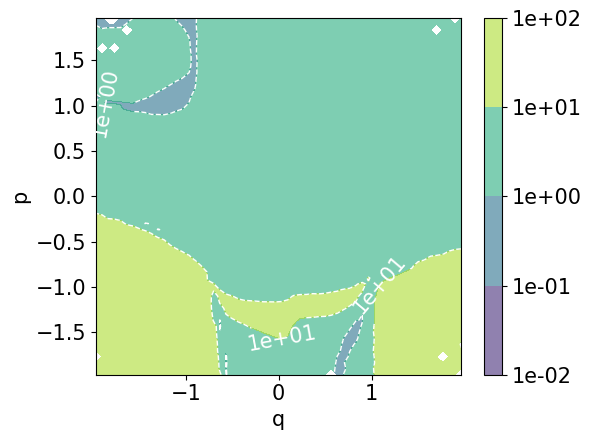

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter
from scipy.stats import binned_statistic_2d

# ---------------------------------------------------
# Shared settings
# ---------------------------------------------------
bands      = [1e-2, 1e-1, 1, 1e+1, 1e+2]
fontsize   = 15
norm       = LogNorm(vmin=bands[0], vmax=bands[-1])
cbar_fmt   = ScalarFormatter(useMathText=True)
cbar_ticks = bands

# ---------------------------------------------------
# Helper: bin (q,p,h) onto a grid for contouring
# ---------------------------------------------------
def compute_binned_mean(q, p, h, bins=60, range=[[-2,2],[-2,2]]):
    stat, xe, ye, _ = binned_statistic_2d(
        q, p, h, statistic="mean",
        bins=bins, range=range
    )
    xc = (xe[:-1] + xe[1:]) / 2
    yc = (ye[:-1] + ye[1:]) / 2
    return stat.T, np.meshgrid(xc, yc)

# ---------------------------------------------------
# Unpack your data
# ---------------------------------------------------
# 1) Uniform grid
Q, P       = res_grid["Q"], res_grid["P"]
h_grid     = res_grid["h_error"]

# 2) Uniform-random
coords_rand = res_rand["coords"]
q_rand, p_rand = coords_rand.T
h_rand       = res_rand["h_error"]
stat_rand, (Qr, Pr) = compute_binned_mean(q_rand, p_rand, h_rand)

# 3) Gaussian
coords_gauss = res_gauss["coords"]
q_gauss, p_gauss = coords_gauss.T
h_gauss        = res_gauss["h_error"]
stat_gauss, (Qg, Pg) = compute_binned_mean(q_gauss, p_gauss, h_gauss)

# ---------------------------------------------------
# Plot 1: Grid data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Q, P, h_grid,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Q, P, h_grid,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Grid $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 2: Uniform‐random data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qr, Pr, stat_rand,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qr, Pr, stat_rand,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Uniform‐Random $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Plot 3: Gaussian data with discrete filled bands
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6,4.5))
cf = ax.contourf(
    Qg, Pg, stat_gauss,
    levels=bands,
    cmap='viridis',
    norm=norm,
    alpha=0.6
)
cs = ax.contour(
    Qg, Pg, stat_gauss,
    levels=bands,
    colors='white',
    linestyles='--',
    linewidths=1.0
)
ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors='white')

#ax.set_title("Gaussian $|H_{pred}-H_{true}|$ bands", fontsize=fontsize)
ax.set_xlabel("q", fontsize=fontsize)
ax.set_ylabel("p", fontsize=fontsize)
ax.tick_params(labelsize=fontsize)

cbar = plt.colorbar(cf, ax=ax, ticks=cbar_ticks, format=cbar_fmt)
cbar.ax.yaxis.set_major_formatter(lambda x, _: f"{x:.0e}")
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()
plt.show()


### For Henon Heiles ###

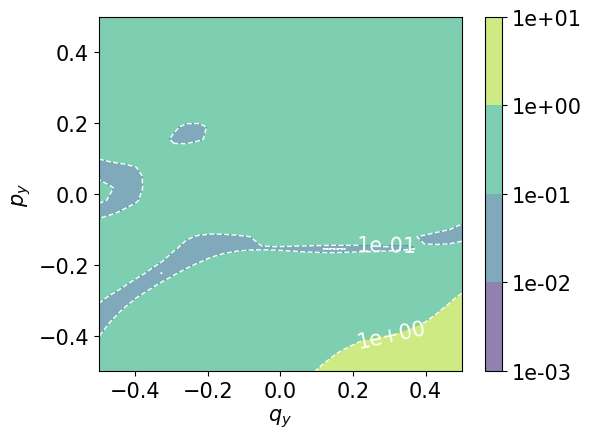

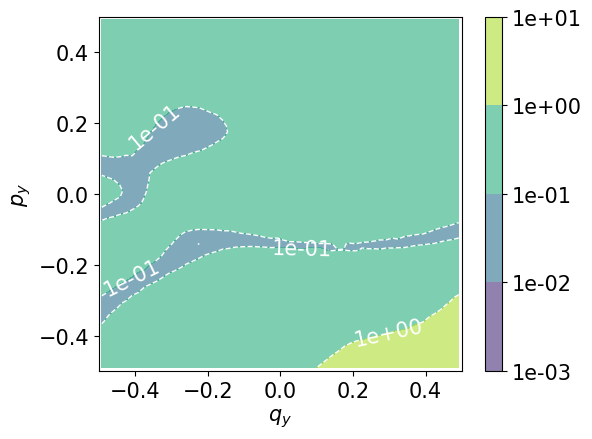

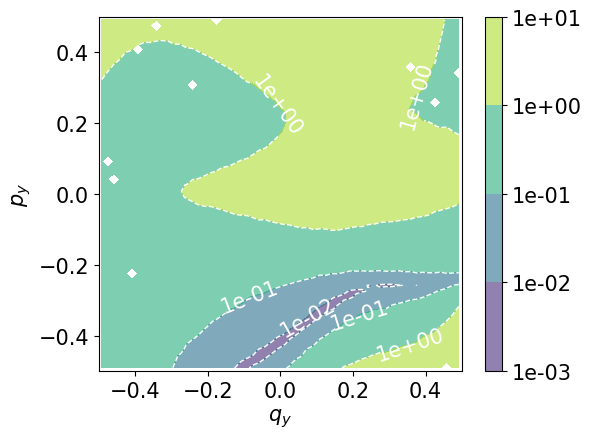

In [49]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from scipy.stats import binned_statistic_2d

# ---------- true Hamiltonian and dynamics helpers ----------
def true_h_point_full(Y: torch.Tensor) -> np.ndarray:
    y_np = Y.cpu().numpy()
    qx = y_np[:, 0]
    qy = y_np[:, 1]
    px = y_np[:, 2]
    py = y_np[:, 3]
    return 0.5 * (px**2 + py**2) + 0.5 * (qx**2 + qy**2) + (qx**2) * qy - (qy**3) / 3.0

def H_pred_fn_full(Y: torch.Tensor, model, device="cpu") -> torch.Tensor:
    """
    Y: [B,4] tensor: [q_x, q_y, p_x, p_y]
    returns: [B] predicted Hamiltonian scalar K from model.cal_H
    """
    with torch.no_grad():
        q = Y[:, :2].unsqueeze(1)  # [B,1,2]
        p = Y[:, 2:].unsqueeze(1)  # [B,1,2]
        x = torch.cat([q, p], dim=2)  # [B,1,4]
        K = model.cal_H(x.squeeze(1))  # [B,1]
    return K.squeeze(1)  # [B]

def slice_and_plot(qx_fixed, px_fixed, model, num_pts=100, band_levels=None, device="cpu"):
    if band_levels is None:
        band_levels = [1e-3, 1e-2, 1e-1, 1, 1e+1]
    norm = LogNorm(vmin=band_levels[0], vmax=band_levels[-1])
    fontsize = 15

    # Build grid over qy, py
    qy_vals = np.linspace(-0.5, 0.5, num_pts)
    py_vals = np.linspace(-0.5, 0.5, num_pts)
    Qy, Py = np.meshgrid(qy_vals, py_vals, indexing="xy")  # (num_pts,num_pts)

    # Flatten and build full state [qx, qy, px, py]
    qx_arr = np.full((num_pts * num_pts,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_pts * num_pts,), px_fixed, dtype=np.float32)
    qy_flat = Qy.ravel().astype(np.float32)
    py_flat = Py.ravel().astype(np.float32)
    Y = torch.tensor(
        np.stack([qx_arr, qy_flat, px_arr, py_flat], axis=1),
        dtype=torch.float32,
        device=device,
    )  # [M,4]

    # Predictions
    H_pred = H_pred_fn_full(Y, model, device=device).cpu().numpy()  # (M,)
    H_true = true_h_point_full(Y)  # (M,)

    # Offset correction
    offset = np.mean(H_pred - H_true)
    H_pred_corr = H_pred - offset
    h_err = np.abs(H_pred_corr - H_true)  # (M,)

    h_error_grid = h_err.reshape(num_pts, num_pts)

    # Plot slice
    fig, ax = plt.subplots(figsize=(6, 4.5))
    cf = ax.contourf(
        Qy, Py, h_error_grid,
        levels=band_levels,
        cmap="viridis",
        norm=norm,
        alpha=0.6
    )
    cs = ax.contour(
        Qy, Py, h_error_grid,
        levels=band_levels,
        colors="white",
        linestyles="--",
        linewidths=1.0
    )
    ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors="white")
    ax.set_xlabel(r"$q_y$", fontsize=fontsize)
    ax.set_ylabel(r"$p_y$", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(cf, ax=ax, ticks=band_levels, format=ScalarFormatter(useMathText=True))
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
    cbar.ax.tick_params(labelsize=fontsize)
    plt.tight_layout()
    plt.show()

    return {
        "Qy": Qy,
        "Py": Py,
        "h_error_grid": h_error_grid,
        "offset": offset,
        "mean_abs_h": float(h_err.mean())
    }

def evaluate_random_and_gauss_slice(qx_fixed, px_fixed, model, num_samples=100000, bins=60, rng=[[-0.5,0.5],[-0.5,0.5]], device="cpu"):
    # Uniform random over qy, py
    qy_rand = np.random.uniform(rng[0][0], rng[0][1], size=num_samples)
    py_rand = np.random.uniform(rng[1][0], rng[1][1], size=num_samples)
    qx_arr = np.full((num_samples,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_samples,), px_fixed, dtype=np.float32)

    Y_rand = torch.tensor(
        np.stack([qx_arr, qy_rand, px_arr, py_rand], axis=1),
        dtype=torch.float32,
        device=device,
    )  # [N,4]

    H_pred_rand = H_pred_fn_full(Y_rand, model, device=device).cpu().numpy()
    H_true_rand = true_h_point_full(Y_rand)
    offset_rand = np.mean(H_pred_rand - H_true_rand)
    H_pred_corr_rand = H_pred_rand - offset_rand
    h_err_rand = np.abs(H_pred_corr_rand - H_true_rand)

    stat_rand, xedges, yedges, _ = binned_statistic_2d(
        qy_rand, py_rand, h_err_rand, statistic="mean", bins=bins, range=rng
    )
    xc = (xedges[:-1] + xedges[1:]) / 2
    yc = (yedges[:-1] + yedges[1:]) / 2
    Qr, Pr = np.meshgrid(xc, yc, indexing="xy")

    # Plot uniform-random
    bands = [1e-3, 1e-2, 1e-1, 1, 1e+1]
    norm = LogNorm(vmin=bands[0], vmax=bands[-1])
    fontsize = 15

    fig, ax = plt.subplots(figsize=(6, 4.5))
    cf = ax.contourf(
        Qr, Pr, stat_rand.T,
        levels=bands,
        cmap="viridis",
        norm=norm,
        alpha=0.6
    )
    cs = ax.contour(
        Qr, Pr, stat_rand.T,
        levels=bands,
        colors="white",
        linestyles="--",
        linewidths=1.0
    )
    ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors="white")
    ax.set_xlabel(r"$q_y$", fontsize=fontsize)
    ax.set_ylabel(r"$p_y$", fontsize=fontsize)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(cf, ax=ax, ticks=bands, format=ScalarFormatter(useMathText=True))
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
    cbar.ax.tick_params(labelsize=fontsize)
    plt.tight_layout()
    plt.show()

    # Gaussian with std=0.5 (cov diag 0.25)
    mean = [0, 0]
    cov = [[0.25, 0], [0, 0.25]]
    qy_gauss, py_gauss = np.random.multivariate_normal(mean, cov, size=num_samples).T
    Y_gauss = torch.tensor(
        np.stack([qx_arr, qy_gauss, px_arr, py_gauss], axis=1),
        dtype=torch.float32,
        device=device,
    )
    H_pred_gauss = H_pred_fn_full(Y_gauss, model, device=device).cpu().numpy()
    H_true_gauss = true_h_point_full(Y_gauss)
    offset_gauss = np.mean(H_pred_gauss - H_true_gauss)
    H_pred_corr_gauss = H_pred_gauss - offset_gauss
    h_err_gauss = np.abs(H_pred_corr_gauss - H_true_gauss)

    stat_gauss, xedges2, yedges2, _ = binned_statistic_2d(
        qy_gauss, py_gauss, h_err_gauss, statistic="mean", bins=bins, range=rng
    )
    xc2 = (xedges2[:-1] + xedges2[1:]) / 2
    yc2 = (yedges2[:-1] + yedges2[1:]) / 2
    Qg, Pg = np.meshgrid(xc2, yc2, indexing="xy")

    fig, ax = plt.subplots(figsize=(6, 4.5))
    cf = ax.contourf(
        Qg, Pg, stat_gauss.T,
        levels=bands,
        cmap="viridis",
        norm=norm,
        alpha=0.6
    )
    cs = ax.contour(
        Qg, Pg, stat_gauss.T,
        levels=bands,
        colors="white",
        linestyles="--",
        linewidths=1.0
    )
    ax.clabel(cs, fmt=lambda v: f"{v:.0e}", inline=True, fontsize=fontsize, colors="white")
    ax.set_xlabel(r"$q_y$", fontsize=fontsize)
    ax.set_ylabel(r"$p_y$", fontsize=fontsize)
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.tick_params(labelsize=fontsize)
    cbar = plt.colorbar(cf, ax=ax, ticks=bands, format=ScalarFormatter(useMathText=True))
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0e}"))
    cbar.ax.tick_params(labelsize=fontsize)
    plt.tight_layout()
    plt.show()

    return {
        "rand": {
            "Qr": Qr,
            "Pr": Pr,
            "stat_rand": stat_rand,
            "offset": offset_rand,
            "mean_abs_h": float(h_err_rand.mean())
        },
        "gauss": {
            "Qg": Qg,
            "Pg": Pg,
            "stat_gauss": stat_gauss,
            "offset": offset_gauss,
            "mean_abs_h": float(h_err_gauss.mean())
        },
    }


# ---------- Example call ----------
device = "cpu"  # or "cuda" if available and model on GPU
slice_res = slice_and_plot(qx_fixed=0.1, px_fixed=0.2, num_pts=30, model=model, device=device)
rand_gauss_res = evaluate_random_and_gauss_slice(
    qx_fixed=0.1,
    px_fixed=0.2,
    model=model,
    num_samples=50000,
    device=device
)

In [52]:
def compute_h_error_from_Y(Y: torch.Tensor, model, device="cpu"):
    """Offset-corrected absolute error vector for given inputs Y."""
    H_pred = H_pred_fn_full(Y.to(device), model, device=device).cpu().numpy()
    H_true = true_h_point_full(Y.to(device))
    offset = np.mean(H_pred - H_true)
    H_pred_corr = H_pred - offset
    h_err = np.abs(H_pred_corr - H_true)
    return h_err  # flat numpy array

def get_h_error_grid(qx_fixed, px_fixed, model, device="cpu", num_pts=100):
    """Grid slice error over (q_y,p_y) same as slice_and_plot."""
    qy_vals = np.linspace(-0.5, 0.5, num_pts)
    py_vals = np.linspace(-0.5, 0.5, num_pts)
    Qy, Py = np.meshgrid(qy_vals, py_vals, indexing="xy")
    qx_arr = np.full((num_pts * num_pts,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_pts * num_pts,), px_fixed, dtype=np.float32)
    qy_flat = Qy.ravel().astype(np.float32)
    py_flat = Py.ravel().astype(np.float32)
    Y_grid = torch.tensor(
        np.stack([qx_arr, qy_flat, px_arr, py_flat], axis=1),
        dtype=torch.float32,
        device=device,
    )
    return compute_h_error_from_Y(Y_grid, model, device=device)

def get_h_error_random_and_gauss(qx_fixed, px_fixed, model, device="cpu", num_samples=100000, rng=[[-0.5,0.5],[-0.5,0.5]]):
    """Sample random-uniform and Gaussian and return raw h_error vectors."""
    # random uniform
    qy_rand = np.random.uniform(rng[0][0], rng[0][1], size=num_samples)
    py_rand = np.random.uniform(rng[1][0], rng[1][1], size=num_samples)
    qx_arr = np.full((num_samples,), qx_fixed, dtype=np.float32)
    px_arr = np.full((num_samples,), px_fixed, dtype=np.float32)
    Y_rand = torch.tensor(
        np.stack([qx_arr, qy_rand, px_arr, py_rand], axis=1),
        dtype=torch.float32,
        device=device,
    )
    h_err_rand = compute_h_error_from_Y(Y_rand, model, device=device)

    # Gaussian (mean zero, independent std=0.5)
    mean = [0, 0]
    cov = [[0.25, 0], [0, 0.25]]
    qy_gauss, py_gauss = np.random.multivariate_normal(mean, cov, size=num_samples).T
    Y_gauss = torch.tensor(
        np.stack([qx_arr, qy_gauss.astype(np.float32), px_arr, py_gauss.astype(np.float32)], axis=1),
        dtype=torch.float32,
        device=device,
    )
    h_err_gauss = compute_h_error_from_Y(Y_gauss, model, device=device)

    return h_err_rand, h_err_gauss

def summarize(name, arr):
    mean = arr.mean()
    sem = arr.std(ddof=1) / np.sqrt(len(arr))
    print(f"{name}: {mean:.3e} ± {sem:.3e} (n={len(arr)})")

In [53]:
# --------- Example usage ----------
device = "cpu"  # or "cuda" if model is on GPU
# make sure model is on device
model = model.to(device)

qx_fixed = 0.1
px_fixed = 0.2

h_err_grid = get_h_error_grid(qx_fixed, px_fixed, model, device=device, num_pts=30)
h_err_rand, h_err_gauss = get_h_error_random_and_gauss(qx_fixed, px_fixed, model, device=device, num_samples=50000)

summarize("Grid", h_err_grid)
summarize("Random", h_err_rand)
summarize("Gaussian", h_err_gauss)

Grid: 5.557e-01 ± 2.635e-02 (n=900)
Random: 5.031e-01 ± 2.857e-03 (n=50000)
Gaussian: 1.659e+00 ± 9.618e-03 (n=50000)
